In [1]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/Rn222Study


In [2]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os
import time

plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Import the nEXO sensitivity classes

import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

import importlib
importlib.reload(plt)
importlib.reload( nEXOFitWorkspace )

<module 'nEXOFitWorkspace' from '../../../modules/nEXOFitWorkspace.py'>

# Define the functions

In [4]:
def Gaussian(x,A,mu,sig):
    return A/np.sqrt(2*np.pi*sig**2) * np.exp(-(x-mu)**2/(2*sig**2))

In [5]:
def PlotPullDistributions(pull_df,yscale='linear', save=False, \
                                  outputfile='output.png',xrange=[-6.,6.]):
    
    variable_names_list = list(pull_df['best_fit_parameters'].iloc[0].keys())
    
    num_parameters = len(pull_df['best_fit_parameters'].iloc[0])

    plt.rcParams.update({'font.size': 18})
    plt.rcParams['figure.figsize'] = (12,10)

    nrows = 4
    ncols = 4

    fig, ax = plt.subplots(ncols=ncols,nrows=nrows,sharex=True,sharey=False,gridspec_kw={'hspace':0,'wspace':0})

    xcoord = 0
    ycoord = 0

    for i in range(num_parameters):
        xcoord = i % nrows
        ycoord = i // nrows

        var_name = variable_names_list[i]

        this_best_fit = []
        this_best_fit_error = []
        this_input_parameter = []

        for index,row in pull_df.iterrows():
            this_best_fit.append( row['best_fit_parameters'][var_name] )
            this_best_fit_error.append( row['best_fit_errors'][var_name] )
            this_input_parameter.append( row['input_parameters'][i] )

        this_best_fit = np.array(this_best_fit)
        this_best_fit_error = np.array(this_best_fit_error)
        this_input_parameter = np.array(this_input_parameter)

        bins = np.linspace(xrange[0],xrange[1],100)
        this_hist = hl.hist( (this_best_fit - this_input_parameter)/this_best_fit_error,\
                           bins=bins)

        bin_width = bins[1]-bins[0]

        hl.plot1d(ax[xcoord,ycoord],this_hist,label=var_name)

        ax[xcoord,ycoord].legend(fontsize=10,loc='upper right')
        ax[xcoord,ycoord].set_yscale(yscale)
        ax[xcoord,ycoord].set_yticks([])
        
        ylimits = ax[xcoord,ycoord].get_ylim()
        if yscale == 'linear':
            ax[xcoord,ycoord].set_ylim(ylimits[0],np.max(this_hist.values)*1.3)
        elif yscale == 'log':
            ax[xcoord,ycoord].set_ylim(ylimits[0],np.max(this_hist.values)*10.)

        xgauss = bins
        ygauss = Gaussian(xgauss,\
                          float(len(pull_df)),\
                          0., 1.)
        ax[xcoord,ycoord].plot(xgauss,ygauss*bin_width,':k',linewidth=1)
        
        pulls = (this_best_fit - this_input_parameter)/this_best_fit_error
        
        outliers_mask = (np.abs(pulls) > 20.) | (pulls!=pulls)
        
        input_xval = np.ones(10)*np.mean( pulls[np.invert(outliers_mask)] )
        input_yval = np.linspace(ax[xcoord,ycoord].get_ylim()[0],\
                                ax[xcoord,ycoord].get_ylim()[1], 10)
        ax[xcoord,ycoord].plot(input_xval,input_yval,'--b',linewidth=1)
        
        ax[xcoord,ycoord].set_xlim(xrange[0],xrange[1])
            

    for i in range(num_parameters,nrows*ncols):
        xcoord = i % nrows
        ycoord = i // nrows
        ax[xcoord,ycoord].set_yticks([])
        
    if save:
        plt.savefig(outputfile,dpi=200,bbox_inches='tight')
    

In [6]:
def PlotParameterInputDistributions(pull_df, yscale='linear', save=False, \
                                  outputfile='output.png'):
    
    variable_names_list = list(pull_df['best_fit_parameters'].iloc[0].keys())
    
    num_parameters = len(pull_df['best_fit_parameters'].iloc[0])
    
    plt.rcParams.update({'font.size': 10})
    plt.rcParams['figure.figsize'] = (12,10)

    nrows = 4
    ncols = 4

    fig, ax = plt.subplots(ncols=ncols,nrows=nrows,\
                           sharex=False,sharey=False,\
                           gridspec_kw={'hspace':0.15,'wspace':0.05})

    xcoord = 0
    ycoord = 0

    for i in range(num_parameters):
        xcoord = i % nrows
        ycoord = i // nrows

        var_name = variable_names_list[i]

        this_best_fit = []
        this_best_fit_error = []
        this_input_parameter = []

        for index,row in pull_df.iterrows():
            this_best_fit.append( row['best_fit_parameters'][var_name] )
            this_best_fit_error.append( row['best_fit_errors'][var_name] )
            this_input_parameter.append( row['input_parameters'][i] )

        this_best_fit = np.array(this_best_fit)
        this_best_fit_error = np.array(this_best_fit_error)
        this_input_parameter = np.array(this_input_parameter)

        mean = np.mean(this_input_parameter)
        stdev = np.std(this_input_parameter)
        abs_bins = np.linspace(mean-4*stdev,mean+4*stdev,100)
        this_hist_abs = hl.hist( this_input_parameter,\
                           bins=abs_bins)
        hl.plot1d(ax[xcoord,ycoord],this_hist_abs,label=var_name,color='g')

        ax[xcoord,ycoord].legend(fontsize=10,loc='upper right')
        ax[xcoord,ycoord].set_yscale(yscale)
        ax[xcoord,ycoord].set_yticks([])

        if abs_bins[0] < 0. and 'Bb0n' not in var_name:
            ax[xcoord,ycoord].set_xlim(-3.,mean+4*stdev)
        else:
            ax[xcoord,ycoord].set_xlim(mean-4*stdev,mean+4*stdev)
            
        ylimits = ax[xcoord,ycoord].get_ylim()
        if yscale == 'linear':
            ax[xcoord,ycoord].set_ylim(ylimits[0],np.max(this_hist_abs.values)*1.3)
        elif yscale == 'log':
            ax[xcoord,ycoord].set_ylim(ylimits[0],np.max(this_hist_abs.values)*10.)
            
        input_xval = np.ones(10)*np.mean(this_input_parameter)
        input_yval = np.linspace(ax[xcoord,ycoord].get_ylim()[0],\
                                ax[xcoord,ycoord].get_ylim()[1], 10)
        ax[xcoord,ycoord].plot(input_xval,input_yval,'--g',linewidth=1)
        
#         input_xval = np.ones(10)*np.median(this_input_parameter)
#         input_yval = np.linspace(ax[xcoord,ycoord].get_ylim()[0],\
#                                 ax[xcoord,ycoord].get_ylim()[1], 10)
#         ax[xcoord,ycoord].plot(input_xval,input_yval,':g',linewidth=1)
        

    for i in range(num_parameters,nrows*ncols):
        xcoord = i % nrows
        ycoord = i // nrows
        ax[xcoord,ycoord].set_yticks([])
        
    if save:
        plt.savefig(outputfile,dpi=200,bbox_inches='tight')

    

In [7]:
def PlotParameterFitDistributions(pull_df, yscale='linear', save=False, \
                                  outputfile='output.png'):
    
    variable_names_list = list(pull_df['best_fit_parameters'].iloc[0].keys())
    
    num_parameters = len(pull_df['best_fit_parameters'].iloc[0])
    
    plt.rcParams.update({'font.size': 10})
    plt.rcParams['figure.figsize'] = (12,10)

    nrows = 4
    ncols = 4

    fig, ax = plt.subplots(ncols=ncols,nrows=nrows,\
                           sharex=False,sharey=False,\
                           gridspec_kw={'hspace':0.15,'wspace':0.05})

    xcoord = 0
    ycoord = 0

    for i in range(num_parameters):
        xcoord = i % nrows
        ycoord = i // nrows

        var_name = variable_names_list[i]

        this_best_fit = []
        this_best_fit_error = []
        this_input_parameter = []

        for index,row in pull_df.iterrows():
            this_best_fit.append( row['best_fit_parameters'][var_name] )
            this_best_fit_error.append( row['best_fit_errors'][var_name] )
            this_input_parameter.append( row['input_parameters'][i] )

        this_best_fit = np.array(this_best_fit)
        this_best_fit_error = np.array(this_best_fit_error)
        this_input_parameter = np.array(this_input_parameter)

        mean = np.mean(this_best_fit)
        stdev = np.std(this_best_fit)
        abs_bins = np.linspace(mean-4*stdev,mean+4*stdev,100)
        this_hist_abs = hl.hist( this_best_fit,\
                           bins=abs_bins)
        hl.plot1d(ax[xcoord,ycoord],this_hist_abs,label=var_name,color='r')

        ax[xcoord,ycoord].legend(fontsize=10,loc='upper right')
        ax[xcoord,ycoord].set_yscale(yscale)
        ax[xcoord,ycoord].set_yticks([])

        if abs_bins[0] < 0. and 'Bb0n' not in var_name:
            ax[xcoord,ycoord].set_xlim(-3.,mean+4*stdev)
        else:
            ax[xcoord,ycoord].set_xlim(mean-4*stdev,mean+4*stdev)
            
        ylimits = ax[xcoord,ycoord].get_ylim()
        if yscale == 'linear':
            ax[xcoord,ycoord].set_ylim(ylimits[0],np.max(this_hist_abs.values)*1.3)
        elif yscale == 'log':
            ax[xcoord,ycoord].set_ylim(ylimits[0],np.max(this_hist_abs.values)*10.)
            
        input_xval = np.ones(10)*np.mean(this_input_parameter)
        input_yval = np.linspace(ax[xcoord,ycoord].get_ylim()[0],\
                                ax[xcoord,ycoord].get_ylim()[1], 10)
        ax[xcoord,ycoord].plot(input_xval,input_yval,'--r',linewidth=1)
        
#         input_xval = np.ones(10)*np.median(this_input_parameter)
#         input_yval = np.linspace(ax[xcoord,ycoord].get_ylim()[0],\
#                                 ax[xcoord,ycoord].get_ylim()[1], 10)
#         ax[xcoord,ycoord].plot(input_xval,input_yval,':r',linewidth=1)
        

    for i in range(num_parameters,nrows*ncols):
        xcoord = i % nrows
        ycoord = i // nrows
        ax[xcoord,ycoord].set_yticks([])
        
    if save:
        plt.savefig(outputfile,dpi=200,bbox_inches='tight')

    

In [8]:
def ExtractParameterFitValuesToDict(pull_df):
    variable_names_list = list(pull_df['best_fit_parameters'].iloc[0].keys())
    
    parameter_fit_dict = {}
    parameter_input_dict = {}
    parameter_error_dict = {}
    
    for var_name in variable_names_list:
        parameter_fit_dict[var_name] = []
        parameter_input_dict[var_name] = []
        parameter_error_dict[var_name] = []
        
    for index,row in pull_df.iterrows():
        
        for i in range(len(variable_names_list)):
            
            var_name = variable_names_list[i]
            
            parameter_fit_dict[var_name].append(row['best_fit_parameters'][var_name])
            parameter_error_dict[var_name].append(row['best_fit_errors'][var_name])
            parameter_input_dict[var_name].append(row['input_parameters'][i])
            
    return parameter_fit_dict, parameter_error_dict, parameter_input_dict
            

# Loading the data

### First, D-023 model (all normal copper)

In [9]:
#categories_list = ['0.01x','00.1x','00.3x','01.0x','03.0x','10.0x','30.0x','100.0x']
categories_list = ['01.0x']

# outputdir = '/p/lustre2//lenardo1/sensitivity_output/'+\
#             'Jan3_Rn222Study_merged-v10b_OptimizedV1Binning_D023/'
outputdir = '/p/lustre2//lenardo1/sensitivity_output/'+\
            'Jan19_Rn222Study_merged-v10b_OptimizedV1Binning_D023/'


all_files = os.listdir(outputdir)
h5_files = [filename for filename in all_files if filename.endswith('.h5')]

dfdict = dict()

start_time = time.time()
for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list = [pd.read_hdf(outputdir+filename) for filename in h5_files if '_'+category+'_' in filename]
    dfdict[category] = pd.concat(df_list,ignore_index=True)
    print('---> Loaded {} toy datasets at {:4.4} min'.format(len(dfdict[category]),\
                                                             (time.time()-start_time)/60.))

Loading data for 01.0x
---> Loaded 5000 toy datasets at 0.2349 min


In [10]:
# Get the median values of lambda

maskdict = dict()

for key, df in dfdict.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict[key])/len(maskdict[key])))
            
    
        

Running 01.0x
---> Convergence fraction: 0.961


### Next, D-024 model (all electroformed copper)

In [11]:
#categories_list = ['0.01x','00.1x','00.3x','01.0x','03.0x','10.0x','30.0x','100.0x']
categories_list = ['01.0x']

# outputdir_d024 = '/p/lustre2/lenardo1/sensitivity_output/'+\
#                 'Jan3_Rn222Study_merged-v10b_OptimizedV1Binning_D024/'

# outputdir_d024 = '/p/lustre2/lenardo1/sensitivity_output/'+\
#                 'Jan7_Rn222Study_merged-v10b_OptimizedV1Binning_D024_WithNLL/'
outputdir_d024 = '/p/lustre2/lenardo1/sensitivity_output/'+\
                'Jan19_Rn222Study_merged-v10b_OptimizedV1Binning_D024/'

all_files_d024 = os.listdir(outputdir_d024)
h5_files_d024 = [filename for filename in all_files_d024 if filename.endswith('.h5')]

dfdict_d024 = dict()

for category in categories_list:
    print('Loading data for {}'.format(category))
    df_list_d024 = [pd.read_hdf(outputdir_d024+filename) for filename in h5_files_d024 if '_'+category+'_' in filename]
    dfdict_d024[category] = pd.concat(df_list_d024,ignore_index=True)
    print('---> Loaded {} toy datasets'.format(len(dfdict_d024[category])))

Loading data for 01.0x
---> Loaded 5000 toy datasets


In [12]:
# Get the median values of lambda

maskdict_d024 = dict()

for key, df in dfdict_d024.items():
    print('Running {}'.format(key))
    
    good_fit_mask = []
    
    for index,row in df.iterrows():
        if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1:
            good_fit_mask.append(False)
        else:
            good_fit_mask.append(True)
            
    maskdict_d024[key] = np.array(good_fit_mask)
    print('---> Convergence fraction: {:3.3}'.format(np.sum(maskdict_d024[key])/len(maskdict_d024[key])))
       

Running 01.0x
---> Convergence fraction: 0.93


# Make the parameter fit plots

### D-023

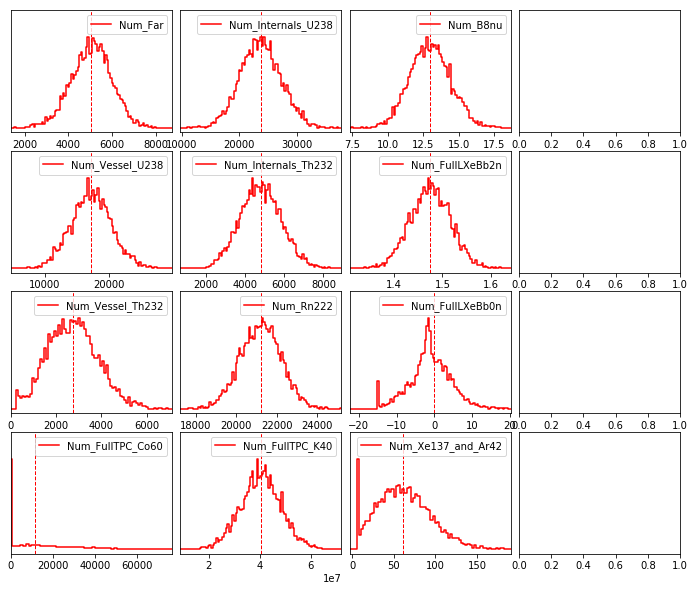

In [13]:
df_d023 = dfdict['01.0x'].loc[maskdict['01.0x']]

PlotParameterFitDistributions(df_d023,yscale='linear',save=True,\
                outputfile='Plots/parameter_fit_distributions_rn222x1_D023_linear.png')


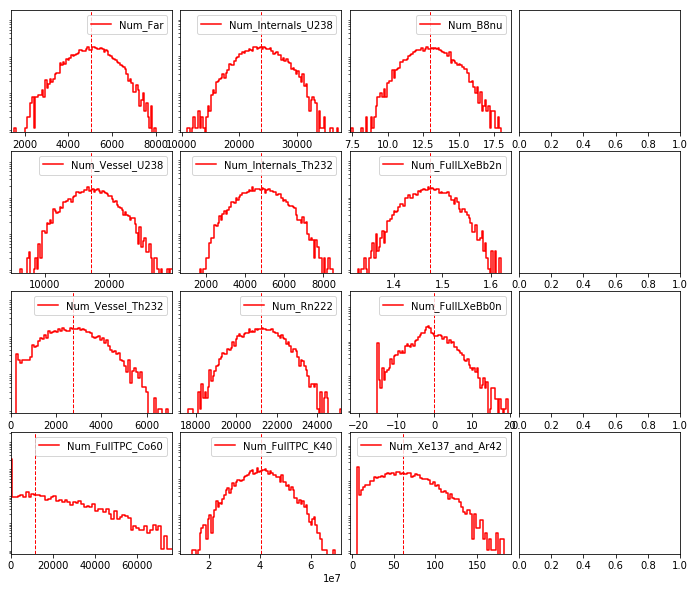

In [14]:
df_d023 = dfdict['01.0x'].loc[maskdict['01.0x']]

PlotParameterFitDistributions(df_d023,yscale='log',save=True,\
                outputfile='Plots/parameter_fit_distributions_rn222x1_D023_log.png')




/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=21223.238821988984, right=21223.238821988984


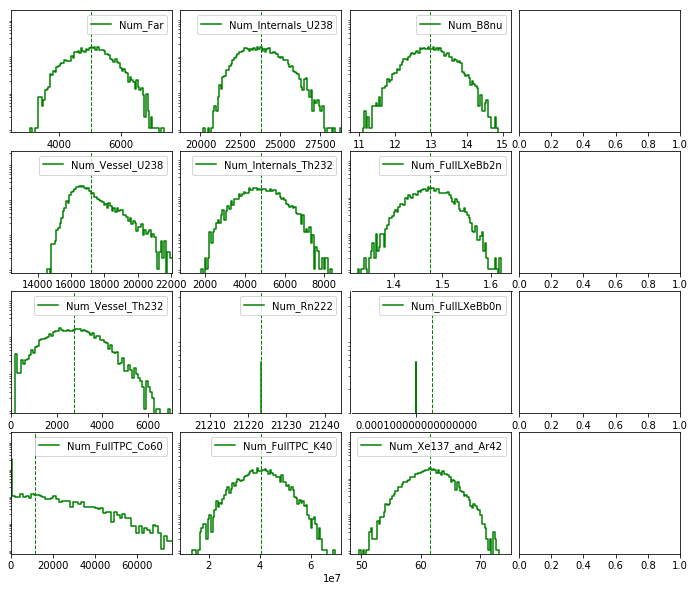

In [15]:

PlotParameterInputDistributions(df_d023,yscale='log',save=True,\
                outputfile='Plots/parameter_input_distributions_rn222x1_D023_log.png')

### D-024

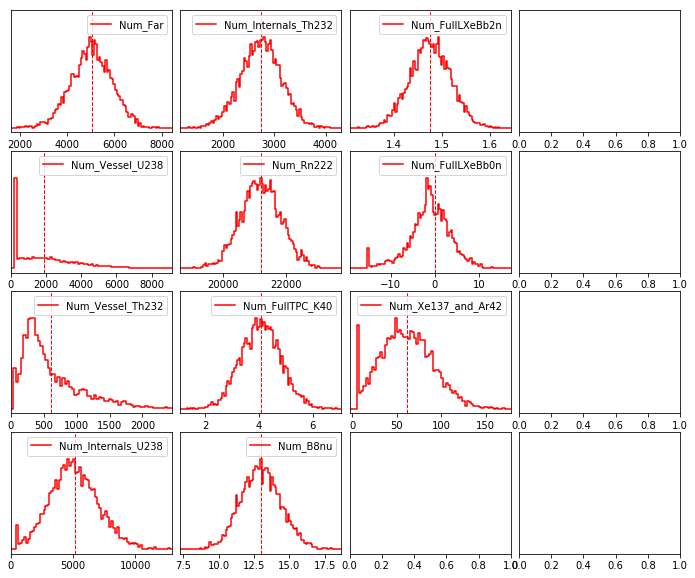

In [16]:
df_d024 = dfdict_d024['01.0x'].loc[maskdict_d024['01.0x']]

PlotParameterFitDistributions(df_d024,yscale='linear',save=True,\
                outputfile='Plots/parameter_fit_distributions_rn222x1_D024_linear.png')


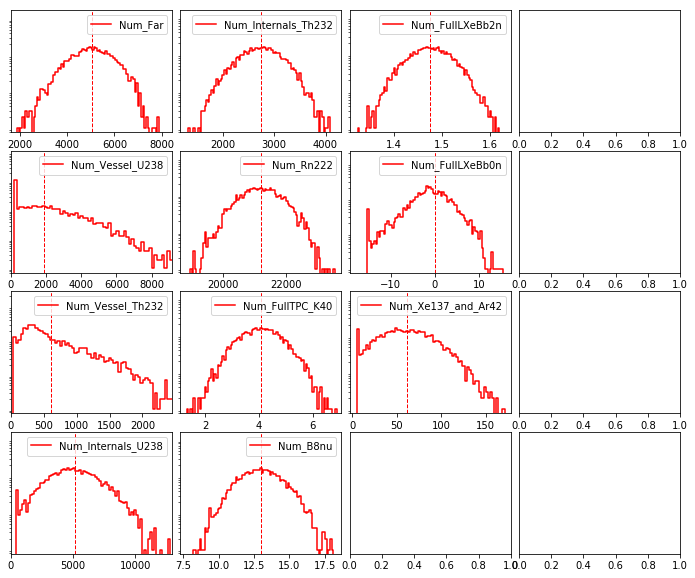

In [19]:
df_d024 = dfdict_d024['01.0x'].loc[maskdict_d024['01.0x']]

PlotParameterFitDistributions(df_d024,yscale='log',save=True,\
                outputfile='Plots/parameter_fit_distributions_rn222x1_D024_log.png')

/g/g20/lenardo1/localpythonpackages/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=21223.238821988984, right=21223.238821988984


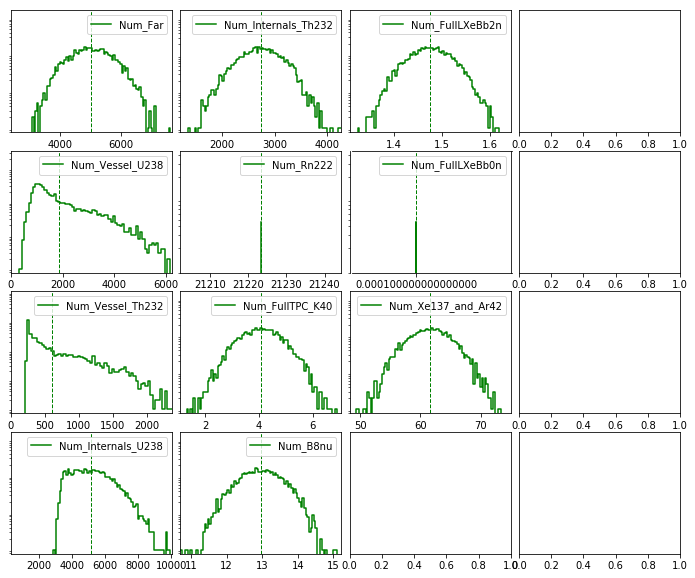

In [20]:

PlotParameterInputDistributions(df_d024,yscale='log',save=True,\
                outputfile='Plots/parameter_input_distributions_rn222x1_D024_log.png')

# Make the pull distributions plots

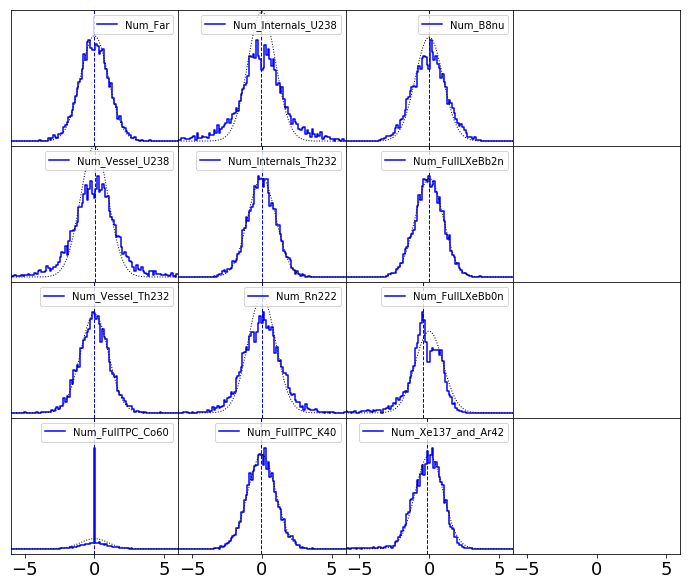

In [21]:
PlotPullDistributions(df_d023,yscale='linear',save=True,\
                outputfile='Plots/pull_distributions_rn222x1_D023_linear.png')


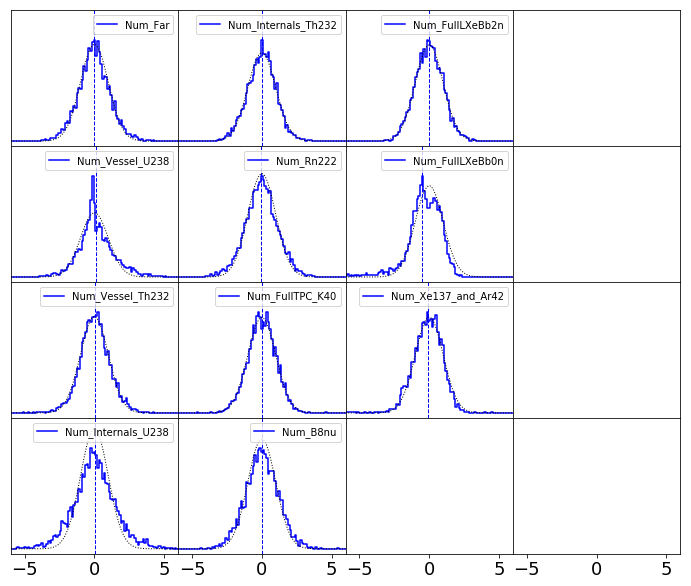

In [22]:
PlotPullDistributions(df_d024,yscale='linear',save=True,\
                outputfile='Plots/pull_distributions_rn222x1_D024_linear.png')


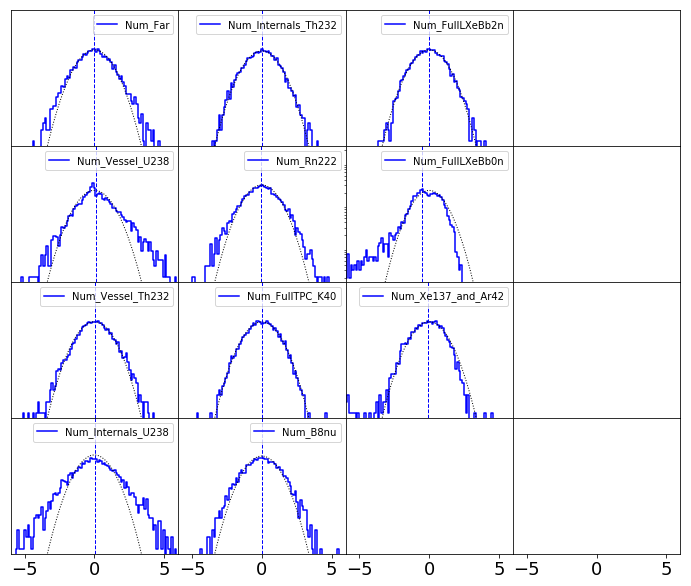

In [23]:
PlotPullDistributions(df_d024,yscale='log',save=True,\
                outputfile='Plots/pull_distributions_rn222x1_D024_log.png', xrange=[-6.,6.])







# Let's look at some correlations between parameters - D024


In [24]:
d024_fit, d024_err, d024_inputs = ExtractParameterFitValuesToDict(df_d024)


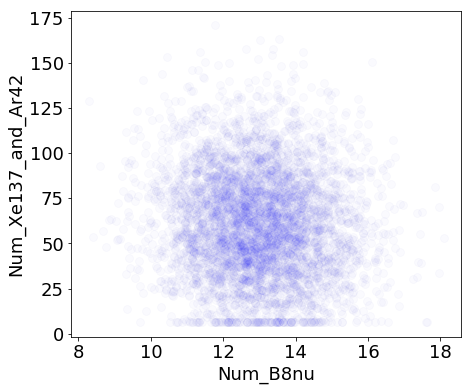

In [25]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


plt.plot(d024_fit['Num_B8nu'],d024_fit['Num_Xe137_and_Ar42'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=8)

plt.xlabel('Num_B8nu')
plt.ylabel('Num_Xe137_and_Ar42')

plt.savefig('Plots/parameter_fit_xe137ar42_vs_b8nu.png',dpi=200,bbox_inches='tight')



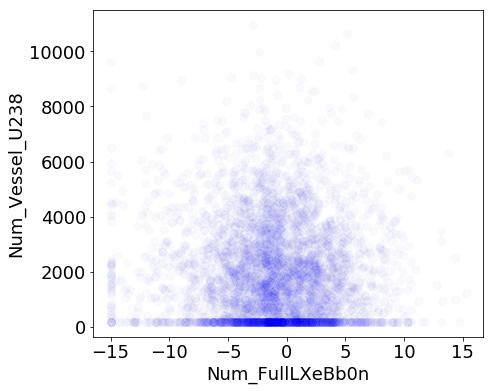

In [26]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


plt.plot(d024_fit['Num_FullLXeBb0n'],d024_fit['Num_Vessel_U238'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=8)

plt.xlabel('Num_FullLXeBb0n')
plt.ylabel('Num_Vessel_U238')

plt.savefig('Plots/parameter_fit_vessel_u238_vs_bb0n.png',dpi=200,bbox_inches='tight')


Text(0, 0.5, 'Num_Vessel_U238')

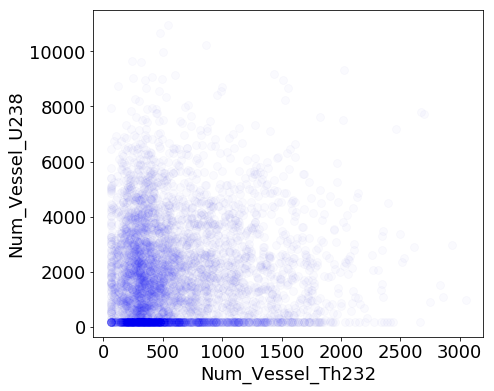

In [27]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


plt.plot(d024_fit['Num_Vessel_Th232'],d024_fit['Num_Vessel_U238'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=8)

plt.xlabel('Num_Vessel_Th232')
plt.ylabel('Num_Vessel_U238')

Text(0, 0.5, 'Num_Vessel_U238')

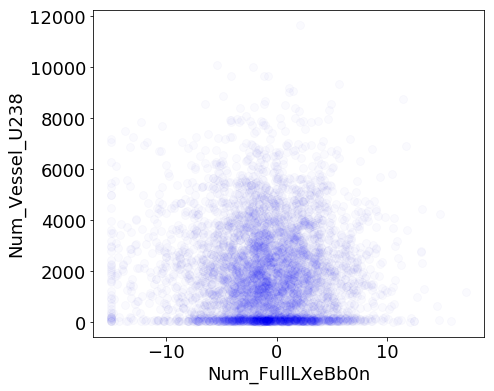

In [28]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


plt.plot(d024_fit['Num_FullLXeBb0n'],d024_fit['Num_Vessel_U238'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=8)

plt.xlabel('Num_FullLXeBb0n')
plt.ylabel('Num_Vessel_U238')

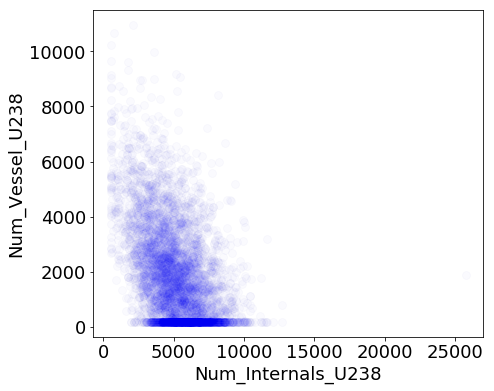

In [28]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


plt.plot(d024_fit['Num_Internals_U238'],d024_fit['Num_Vessel_U238'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=8)

plt.xlabel('Num_Internals_U238')
plt.ylabel('Num_Vessel_U238')
plt.savefig('Plots/parameter_fit_vessel_u238_vs_internals_u238.png',\
            dpi=200,bbox_inches='tight')


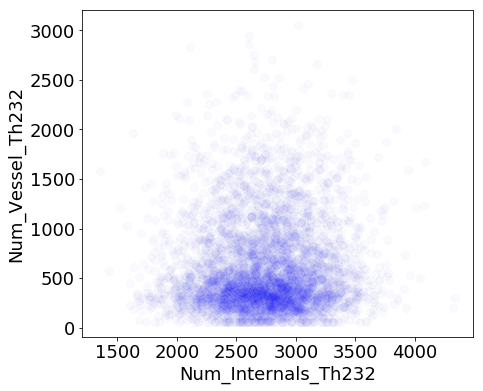

In [29]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


plt.plot(d024_fit['Num_Internals_Th232'],d024_fit['Num_Vessel_Th232'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=8)

plt.xlabel('Num_Internals_Th232')
plt.ylabel('Num_Vessel_Th232')

plt.savefig('Plots/parameter_fit_vessel_th232_vs_internals_th232.png',\
           dpi=200,bbox_inches='tight')



Text(0, 0.5, 'Num_Vessel_U238')

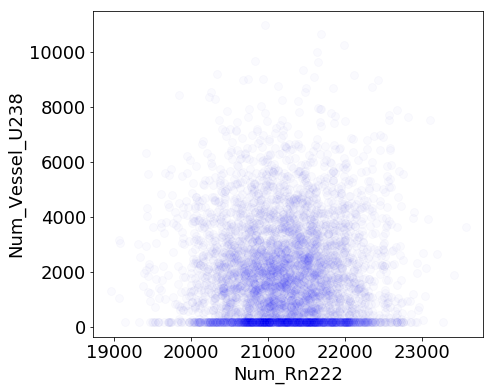

In [30]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


plt.plot(d024_fit['Num_Rn222'],d024_fit['Num_Vessel_U238'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=8)

plt.xlabel('Num_Rn222')
plt.ylabel('Num_Vessel_U238')

# Correlations in D023

In [31]:
d023_fit, d023_err, d023_inputs = ExtractParameterFitValuesToDict(df_d023)


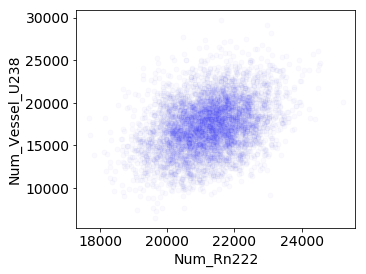

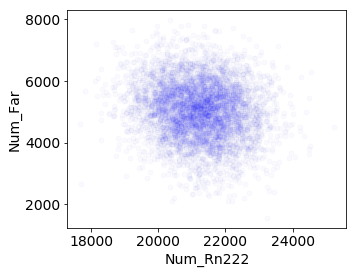

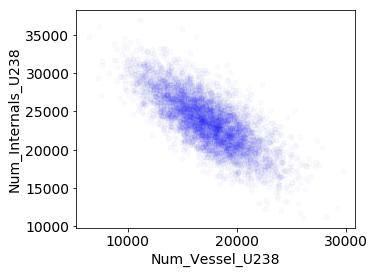

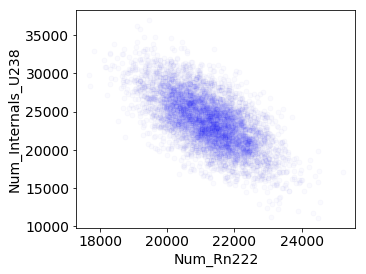

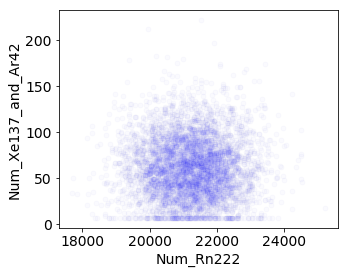

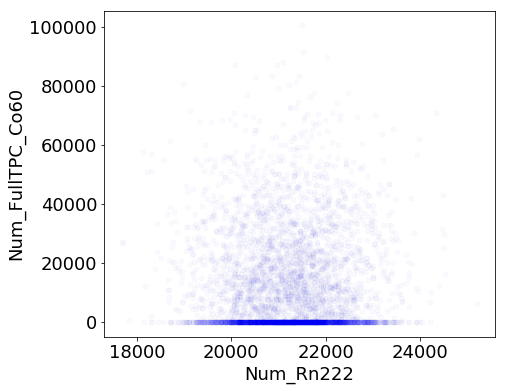

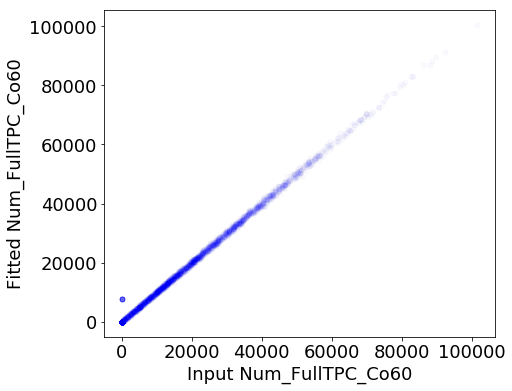

In [32]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (5,4)

plt.figure(1)
plt.plot(d023_fit['Num_Rn222'],d023_fit['Num_Vessel_U238'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=5)
plt.xlabel('Num_Rn222')
plt.ylabel('Num_Vessel_U238')

plt.figure(2)
plt.plot(d023_fit['Num_Rn222'],d023_fit['Num_Far'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=5)
plt.xlabel('Num_Rn222')
plt.ylabel('Num_Far')

plt.figure(3)
plt.plot(d023_fit['Num_Vessel_U238'],d023_fit['Num_Internals_U238'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=5)
plt.xlabel('Num_Vessel_U238')
plt.ylabel('Num_Internals_U238')


plt.figure(4)
plt.plot(d023_fit['Num_Rn222'],d023_fit['Num_Internals_U238'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=5)
plt.xlabel('Num_Rn222')
plt.ylabel('Num_Internals_U238')


plt.figure(5)
plt.plot(d023_fit['Num_Rn222'],d023_fit['Num_Xe137_and_Ar42'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=5)
plt.xlabel('Num_Rn222')
plt.ylabel('Num_Xe137_and_Ar42')

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)
plt.figure(6)
plt.plot(d023_fit['Num_Rn222'],d023_fit['Num_FullTPC_Co60'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=5)
plt.xlabel('Num_Rn222')
plt.ylabel('Num_FullTPC_Co60')

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)


plt.figure(7)
plt.plot(d023_inputs['Num_FullTPC_Co60'],d023_fit['Num_FullTPC_Co60'],'o',\
         color=(0.,0.,0.95,0.02),\
#          markeredgecolor=(0.,0.,0.,0.),\
        markersize=5)
plt.xlabel('Input Num_FullTPC_Co60')
plt.ylabel('Fitted Num_FullTPC_Co60')

plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (7,6)






In [62]:
counter = 0

for i in range(len(d023_fit['Num_Rn222'])):
    if counter > 10:
        break
        
    #print(d023_fit['Num_Rn222'][i])
    if d023_fit['Num_Rn222'][i] > 30000.:
        print('i: {}, File {}, event {}, Rn222 value: {:4.4}'.format(i,int(np.floor(i/50)),\
                                                              i%50,\
                                                             d023_fit['Num_Rn222'][i]))
        counter += 1

i: 98, File 1, event 48, Rn222 value: 3.471e+04
i: 111, File 2, event 11, Rn222 value: 3.133e+04
i: 116, File 2, event 16, Rn222 value: 3.509e+04
i: 117, File 2, event 17, Rn222 value: 4.617e+04
i: 118, File 2, event 18, Rn222 value: 5.319e+04
i: 122, File 2, event 22, Rn222 value: 5.188e+04
i: 127, File 2, event 27, Rn222 value: 4.506e+04
i: 136, File 2, event 36, Rn222 value: 6.093e+04
i: 137, File 2, event 37, Rn222 value: 3.074e+04
i: 139, File 2, event 39, Rn222 value: 4.233e+04
i: 140, File 2, event 40, Rn222 value: 3.207e+04


In [67]:
counter = 0

for i in range(len(d023_fit['Num_Rn222'])):
    if counter > 20:
        break
        
    #print(d023_fit['Num_Rn222'][i])
    if d023_fit['Num_FullTPC_Co60'][i] < d023_inputs['Num_FullTPC_Co60'][i] - 1000.:
        print('i: {}, File {}, event {}, Fitted: {:4.4}, Input: {:4.4}'.format(i,int(np.floor(i/50)),\
                                                              i%50,\
                                                             d023_fit['Num_FullTPC_Co60'][i],\
                                                            d023_inputs['Num_FullTPC_Co60'][i]))
        counter += 1
        
        
        

i: 98, File 1, event 48, Fitted:  0.0, Input: 1.697e+04
i: 99, File 1, event 49, Fitted:  0.0, Input: 2.508e+03
i: 105, File 2, event 5, Fitted:  0.0, Input: 1.54e+03
i: 106, File 2, event 6, Fitted:  0.0, Input: 3.427e+03
i: 111, File 2, event 11, Fitted:  0.0, Input: 1.478e+04
i: 116, File 2, event 16, Fitted:  0.0, Input: 2.297e+04
i: 117, File 2, event 17, Fitted:  0.0, Input: 3.78e+04
i: 118, File 2, event 18, Fitted:  0.0, Input: 5.248e+04
i: 122, File 2, event 22, Fitted:  0.0, Input: 4.43e+04
i: 124, File 2, event 24, Fitted:  0.0, Input: 2.316e+03
i: 127, File 2, event 27, Fitted:  0.0, Input: 3.731e+04
i: 128, File 2, event 28, Fitted:  0.0, Input: 2.869e+03
i: 134, File 2, event 34, Fitted:  0.0, Input: 2.818e+03
i: 136, File 2, event 36, Fitted:  0.0, Input: 6.201e+04
i: 137, File 2, event 37, Fitted:  0.0, Input: 1.51e+04
i: 139, File 2, event 39, Fitted:  0.0, Input: 3.251e+04
i: 140, File 2, event 40, Fitted:  0.0, Input: 1.554e+04
i: 142, File 2, event 42, Fitted:  0.0,

In [71]:
counter = 0

for i in range(len(d023_fit['Num_Rn222'])):
    if int(np.floor(i/50))< 1: continue
    if counter > 40:
        break
        
    #print(d023_fit['Num_Rn222'][i])
    if d023_fit['Num_FullTPC_Co60'][i] < d023_inputs['Num_FullTPC_Co60'][i] + 1000.:
        print('i: {}, File {}, event {}, Fitted: {:4.4}, Input: {:4.4}'.format(i,int(np.floor(i/50)),\
                                                              i%50,\
                                                             d023_fit['Num_FullTPC_Co60'][i],\
                                                            d023_inputs['Num_FullTPC_Co60'][i]))
        counter += 1

i: 51, File 1, event 1, Fitted: 5.919e+03, Input: 5.918e+03
i: 52, File 1, event 2, Fitted: 4.946e+03, Input: 5.768e+03
i: 54, File 1, event 4, Fitted: 2.135e+04, Input: 2.146e+04
i: 57, File 1, event 7, Fitted: 1.902e+04, Input: 1.853e+04
i: 59, File 1, event 9, Fitted: 1.792e+04, Input: 1.806e+04
i: 61, File 1, event 11, Fitted: 6.867e+03, Input: 7.145e+03
i: 63, File 1, event 13, Fitted: 2.959e+04, Input: 2.889e+04
i: 67, File 1, event 17, Fitted: 2.047e+04, Input: 2.108e+04
i: 68, File 1, event 18, Fitted: 4.112e+04, Input: 4.062e+04
i: 72, File 1, event 22, Fitted: 3.346e+04, Input: 3.42e+04
i: 77, File 1, event 27, Fitted: 7.731e+03, Input: 8.337e+03
i: 78, File 1, event 28, Fitted: 3.015e+04, Input: 3.021e+04
i: 79, File 1, event 29, Fitted: 1.418e+04, Input: 1.478e+04
i: 81, File 1, event 31, Fitted: 1.16e+04, Input: 1.135e+04
i: 84, File 1, event 34, Fitted: 2.109e+04, Input: 2.147e+04
i: 87, File 1, event 37, Fitted: 8.02e+03, Input: 7.738e+03
i: 91, File 1, event 41, Fitted:

# Trying to understand means that are way off in pull distributions

In [ ]:
d024_pull = {}

for var in d024_fit.keys():
    
    d024_pull[var] = (np.array(d024_fit[var])-np.array(d024_inputs[var]))/np.array(d024_err[var])
    
    
    
    

In [ ]:

pull_rn222 = hl.hist(d024_pull['Num_Rn222'],bins=np.linspace(-100.,100.,1000))

hl.plot1d(pull_rn222)

plt.xlabel('Rn222 pull')
plt.yscale('log')

print(np.mean(d024_pull['Num_Rn222']))
plt.xlim(-10.,10.)

outliers_mask = np.abs(d024_pull['Num_Rn222'])>7.

print('Pull outliers:')
print(d024_pull['Num_Rn222'][outliers_mask])
print('Errors:')
print('\t{}'.format(np.array(d024_err['Num_Rn222'])[outliers_mask]))
print('Fit vals:')
print('\t{}'.format(np.array(d024_fit['Num_Rn222'])[outliers_mask]))




In [ ]:

pull_rn222 = hl.hist(d024_pull['Num_Xe137'],bins=np.linspace(-100.,100.,1000))

hl.plot1d(pull_rn222)

plt.xlabel('Xe137 pull')
plt.yscale('log')

print(np.mean(d024_pull['Num_Xe137']))
plt.xlim(-10.,10.)

outliers_mask = np.abs(d024_pull['Num_Xe137'])>7.

print('Pull outliers:')
print(d024_pull['Num_Xe137'][outliers_mask])
print('Errors:')
print('\t{}'.format(np.array(d024_err['Num_Xe137'])[outliers_mask]))
print('Fit vals:')
print('\t{}'.format(np.array(d024_fit['Num_Xe137'])[outliers_mask]))

In [ ]:

pull_bb0n = hl.hist(d024_pull['Num_FullLXeBb0n'],bins=np.linspace(-100.,100.,1000))

hl.plot1d(pull_bb0n)

plt.xlabel('Bb0n pull')
plt.yscale('log')

print(np.mean(d024_pull['Num_FullLXeBb0n']))
plt.xlim(-30.,30.)

outliers_mask = np.abs(d024_pull['Num_FullLXeBb0n'])>30.

good_mask = d024_pull['Num_FullLXeBb0n'] == d024_pull['Num_FullLXeBb0n']

print(np.mean(d024_pull['Num_FullLXeBb0n'][np.invert(outliers_mask)&good_mask]))


print('Pull outliers:')
print(d024_pull['Num_FullLXeBb0n'][outliers_mask])
print('Errors:')
print('\t{}'.format(np.array(d024_err['Num_FullLXeBb0n'])[outliers_mask]))
print('Fit vals:')
print('\t{}'.format(np.array(d024_fit['Num_FullLXeBb0n'])[outliers_mask]))

In [ ]:

pull_bb0n = hl.hist(d024_pull['Num_FullLXeBb0n'],bins=np.linspace(-100.,100.,1000))

hl.plot1d(pull_bb0n)

plt.xlabel('Bb0n pull')
plt.yscale('log')

print(np.mean(d024_pull['Num_FullLXeBb0n']))
plt.xlim(-30.,30.)

outliers_mask = np.abs(d024_pull['Num_FullLXeBb0n'])>30.

good_mask = d024_pull['Num_FullLXeBb0n'] == d024_pull['Num_FullLXeBb0n']
bad_mask = np.invert(good_mask)

print(np.mean(d024_pull['Num_FullLXeBb0n'][np.invert(outliers_mask)&good_mask]))


print('Pull outliers:')
print(d024_pull['Num_FullLXeBb0n'][bad_mask])
print('Errors:')
print('\t{}'.format(np.array(d024_err['Num_FullLXeBb0n'])[bad_mask]))
print('Fit vals:')
print('\t{}'.format(np.array(d024_fit['Num_FullLXeBb0n'])[bad_mask]))

# Look at distributions of NLL values

Jason suggested we look at the distribution of NLL values to see if the railing of the Internals_U238 parameter in the D-024 case will affect our fits at all.

In [ ]:




plt.plot(d024_fit['Num_Vessel_U238'],df_d024['best_fit_nll'],\
         'o',color=(1.,0.,0.,0.05))

plt.xlabel('Num_Vessel_U238 best fit')
plt.ylabel('Best fit negative-Log-Likelihood')


plt.savefig('Plots/parameter_fits_vessel_u238_vs_neg_log_likelihood.png',\
         dpi=200,bbox_inches='tight')


In [ ]:
mask = np.array(d024_fit['Num_Vessel_U238']) < 300.

h_vessel0 = hl.hist(df_d024['best_fit_nll'].loc[mask],\
                    bins=np.linspace(-20.,5.,100))

h_vesselnonz = hl.hist(df_d024['best_fit_nll'].loc[np.invert(mask)],\
                       bins=np.linspace(-20.,5.,100))


mean0 = np.mean(df_d024['best_fit_nll'].loc[mask])
sig0 = np.std(df_d024['best_fit_nll'].loc[mask]) / \
            np.sqrt(len(df_d024['best_fit_nll'].loc[mask]))
meannonz = np.mean(df_d024['best_fit_nll'].loc[np.invert(mask)])
signonz = np.std(df_d024['best_fit_nll'].loc[np.invert(mask)]) / \
                np.sqrt(len(df_d024['best_fit_nll'].loc[np.invert(mask)]))

median0 = np.median(df_d024['best_fit_nll'].loc[mask])
mediannonz = np.median(df_d024['best_fit_nll'].loc[np.invert(mask)])


print('Means:')
print('--->  <300: {:4.4} +/- {:4.4}'.format(mean0,sig0))
print('--->  >300: {:4.4} +/- {:4.4}'.format(meannonz,signonz))

print('Medians:')
print('--->  <300: {:4.4}'.format(median0))
print('--->  >300: {:4.4}'.format(mediannonz))


hl.plot1d(h_vessel0,color='b',\
              label='Num_Vessel_U238 < 300\n   Mean = {:4.4} +/- {:4.4}'.format(\
                                                    mean0,sig0))
hl.plot1d(h_vesselnonz,color='g',\
              label='Num_Vessel_U238 > 300\n   Mean = {:4.4} +/- {:4.4}'.format(\
                                                    meannonz,signonz))

plt.xlabel('Best Fit Negative-Log-Likelihood')
plt.legend(fontsize=12,loc='upper left')

plt.xlim(-22.,5.)
ymin = 0.1
ymax = 1000.
plt.yscale('log')
plt.ylim(ymin,ymax)

xmean = np.ones(10)*mean0
ymean = np.linspace(ymin,ymax,10)
plt.plot(xmean,ymean,'--b',linewidth=1)

xmean = np.ones(10)*meannonz
ymean = np.linspace(ymin,ymax,10)
plt.plot(xmean,ymean,'--g',linewidth=1)

plt.savefig('Plots/parameter_fits_nll_distributions_for_diff_cuts_on_vessel_u238.png',\
        dpi=200,bbox_inches='tight')
